In [ ]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

filename = 'output2.csv'
encoding = 'utf-8'


successful_lines = []

with open(filename, 'r', encoding=encoding) as file:
    for line in file:
        try:
            decoded_line = line.encode(encoding).decode(encoding)
            successful_lines.append(line)
        except UnicodeDecodeError:
            print(f"Skipped line due to decoding error: {line}")


with open('filtered_' + filename, 'w', encoding=encoding) as file:
    file.writelines(successful_lines)

data = pd.read_csv('filtered_' + filename)


In [ ]:
selected_data = data[['Date', 'Content']]

In [ ]:
selected_data.head()

Date             Content
0  2019-07-08 04:16:26  Joined the server.
1  2019-08-02 17:36:55  Joined the server.
2  2019-08-05 15:54:58  Joined the server.
3  2019-08-05 15:55:02  Joined the server.
4  2019-08-05 15:55:10  Joined the server.

In [ ]:
selected_data=selected_data.dropna()

In [ ]:
selected_data['Date'] = pd.to_datetime(selected_data['Date'],utc=True)

In [ ]:
selected_data.head()

Date             Content
0 2019-07-08 04:16:26+00:00  Joined the server.
1 2019-08-02 17:36:55+00:00  Joined the server.
2 2019-08-05 15:54:58+00:00  Joined the server.
3 2019-08-05 15:55:02+00:00  Joined the server.
4 2019-08-05 15:55:10+00:00  Joined the server.

In [ ]:
filtered_df = selected_data[(selected_data['Date'] >= '2023-03-20') & (selected_data['Date'] < '2023-04-01')]

In [ ]:
X = filtered_df['Content'].to_list()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
import torch
import pandas as pd
import scipy.special



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare an empty DataFrame to store predictions
all_preds = pd.DataFrame()
i=1
# Iterate through the input data
for x in X:
    if(i%1000==0):
        print(i)
    i+=1
    with torch.no_grad():
        # Tokenize the input sequence
        input_sequence = tokenizer(x, return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_sequence = input_sequence.to(device)  # Move input tensors to CUDA device
        # Get model logits
        logits = model(**input_sequence).logits
        # Softmax to get probabilities
        scores = scipy.special.softmax(logits.cpu().numpy().squeeze())  # Move logits back to CPU for numpy conversion

    # Convert scores to DataFrame
    sentiment_finbert = pd.DataFrame([scores])
    # Concatenate with all_preds DataFrame
    all_preds = pd.concat([all_preds, sentiment_finbert], ignore_index=True)


1000
2000
3000
4000


In [ ]:
filtered_df.reset_index(drop=True, inplace=True)
all_data=pd.concat([filtered_df,all_preds], axis=1)

In [ ]:
new_column_names = {
    0: 'positive',
    1: 'negative',
    2: 'neutral'
}

all_data= all_data.rename(columns=new_column_names)

In [ ]:
all_data

Date  \
0    2023-03-20 00:00:30+00:00   
1    2023-03-20 00:06:34+00:00   
2    2023-03-20 00:54:59+00:00   
3    2023-03-20 01:15:02+00:00   
4    2023-03-20 01:39:41+00:00   
...                        ...   
4694 2023-03-31 21:49:41+00:00   
4695 2023-03-31 22:29:48+00:00   
4696 2023-03-31 23:40:42+00:00   
4697 2023-03-31 23:41:38+00:00   
4698 2023-03-31 23:50:10+00:00   

                                                Content  positive  negative  \
0            You can report scammers in #🚨┃report-scams  0.017093  0.077462   
1     @Gama4T7 please don’t share that here, u can s...  0.027183  0.025469   
2     I participated in the id project, but I don't ...  0.021391  0.034680   
3     Everything will go to zero sooner or later exc...  0.024390  0.365387   
4     Hii, where the commit bnb part button for ICO ...  0.043279  0.016605   
...                                                 ...       ...       ...   
4694  Anyone know how the 10% claimed by lead trader...  0.028104  0.032672   
4695   Good morning Dear Binancians :ex_binance: :cz: ☕  0.079138  0.016252   
4696  hi binance staff can you tell me why my proble...  0.042453  0.222510   
4697              @BinanceHelpDesk @AScore please sir 👆  0.032656  0.025302   
4698                                                 FI  0.058412  0.046549   

       neutral  
0     0.905445  
1     0.947348  
2     0.943929  
3     0.610223  
4     0.940116  
...        ...  
4694  0.939224  
4695  0.904610  
4696  0.735038  
4697  0.942042  
4698  0.895039  

[4699 rows x 5 columns]

In [ ]:
import pandas as pd


all_data['Hour'] = all_data['Date'].dt.ceil('H')
all_data['Day'] = all_data['Date'].dt.ceil('D')

all_data.head()


Date  \
0 2023-03-20 00:00:30+00:00   
1 2023-03-20 00:06:34+00:00   
2 2023-03-20 00:54:59+00:00   
3 2023-03-20 01:15:02+00:00   
4 2023-03-20 01:39:41+00:00   

                                             Content  positive  negative  \
0         You can report scammers in #🚨┃report-scams  0.017093  0.077462   
1  @Gama4T7 please don’t share that here, u can s...  0.027183  0.025469   
2  I participated in the id project, but I don't ...  0.021391  0.034680   
3  Everything will go to zero sooner or later exc...  0.024390  0.365387   
4  Hii, where the commit bnb part button for ICO ...  0.043279  0.016605   

    neutral                      Hour                       Day  
0  0.905445 2023-03-20 01:00:00+00:00 2023-03-21 00:00:00+00:00  
1  0.947348 2023-03-20 01:00:00+00:00 2023-03-21 00:00:00+00:00  
2  0.943929 2023-03-20 01:00:00+00:00 2023-03-21 00:00:00+00:00  
3  0.610223 2023-03-20 02:00:00+00:00 2023-03-21 00:00:00+00:00  
4  0.940116 2023-03-20 02:00:00+00:00 2023-03-21 00:00:00+00:00

## hour sentiment

In [ ]:
hourly_sentiment = all_data.groupby(pd.Grouper(key='Hour', freq='H')).agg({
    'positive': 'mean',
    'negative': 'mean',
    'neutral': 'mean'
}).reset_index()

In [ ]:
hourly_sentiment = hourly_sentiment.dropna()

In [ ]:
hourly_sentiment['Hour'] = pd.to_datetime(hourly_sentiment['Hour'])
hourly_sentiment['Hour'] = hourly_sentiment['Hour'].dt.tz_localize(None)

In [ ]:
hourly_sentiment = hourly_sentiment.set_index('Hour')

In [ ]:
complete_index = pd.date_range(start='2023-03-20', end='2023-04-01', freq='H')

In [ ]:

complete_df = pd.DataFrame(index=complete_index, columns=hourly_sentiment.columns)
complete_df['positive'] = 0
complete_df['negative'] = 0
complete_df['neutral'] = 1

for hour in complete_index:
    # Check if the hour exists in the original DataFrame
    if hour in hourly_sentiment.index:
        continue
    else:
        # Concatenate the corresponding row from complete_df
        hourly_sentiment = pd.concat([hourly_sentiment, complete_df.loc[[hour]]])


In [ ]:
hourly_sentiment_sorted = hourly_sentiment.sort_index()

In [ ]:
hourly_sentiment_sorted

positive  negative   neutral
2023-03-20 00:00:00  0.000000  0.000000  1.000000
2023-03-20 01:00:00  0.021889  0.045871  0.932241
2023-03-20 02:00:00  0.029899  0.113325  0.856775
2023-03-20 03:00:00  0.121052  0.039788  0.839161
2023-03-20 04:00:00  0.121189  0.029374  0.849437
...                       ...       ...       ...
2023-03-31 20:00:00  0.085038  0.065082  0.849880
2023-03-31 21:00:00  0.120638  0.042057  0.837305
2023-03-31 22:00:00  0.039514  0.103802  0.856685
2023-03-31 23:00:00  0.079138  0.016252  0.904610
2023-04-01 00:00:00  0.044507  0.098121  0.857373

[289 rows x 3 columns]

## day sentiment

In [ ]:
daily_sentiment = all_data.groupby(pd.Grouper(key='Date', freq='D')).agg({
    'positive': 'mean',
    'negative': 'mean',
    'neutral': 'mean'
}).reset_index()


In [ ]:
daily_sentiment = daily_sentiment.dropna()

In [ ]:
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
daily_sentiment['Date'] = daily_sentiment['Date'].dt.tz_localize(None)

In [ ]:
daily_sentiment = daily_sentiment.set_index('Date')

In [ ]:
complete_index = pd.date_range(start='2023-05-31', end='2023-07-01', freq='D')

In [ ]:
daily_sentiment_sorted = daily_sentiment.sort_index()

In [ ]:
daily_sentiment_sorted

positive  negative   neutral
Date                                    
2023-03-20  0.075657  0.067800  0.856543
2023-03-21  0.098020  0.071563  0.830417
2023-03-22  0.082404  0.068851  0.848745
2023-03-23  0.068908  0.093714  0.837378
2023-03-24  0.083128  0.100864  0.816008
2023-03-25  0.111851  0.070841  0.817308
2023-03-26  0.083284  0.089351  0.827366
2023-03-27  0.074230  0.070798  0.854972
2023-03-28  0.085851  0.079809  0.834340
2023-03-29  0.082438  0.094043  0.823519
2023-03-30  0.075451  0.070941  0.853609
2023-03-31  0.080779  0.075942  0.843280

## Combine with DNN

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/eth airdrop-biggest-2023/eth-airdrop-biggest-2023.csv')

In [ ]:
data.head()

timestamp    number  gas_used  gas_limit  base_fee_per_gas
0  2023-03-21 00:00:11 UTC  16872313  29872569   30000000       14709149536
1  2023-03-21 00:00:23 UTC  16872314  13937940   30000000       16532173214
2  2023-03-21 00:00:35 UTC  16872315  19559490   30000000       16385855215
3  2023-03-21 00:00:47 UTC  16872316  13826473   30000000       17008448073
4  2023-03-21 00:00:59 UTC  16872317  20820719   30000000       16842115798

In [ ]:
import pandas as pd
new_df = data.drop_duplicates(subset='number', keep='first')

In [ ]:
new_df=new_df[["timestamp","number","gas_used","gas_limit","base_fee_per_gas"]]

In [ ]:
new_df["base_fee_per_gas"] = new_df["base_fee_per_gas"]*10**-9

In [ ]:
new_df.head()

timestamp    number  gas_used  gas_limit  base_fee_per_gas
0  2023-03-21 00:00:11 UTC  16872313  29872569   30000000         14.709150
1  2023-03-21 00:00:23 UTC  16872314  13937940   30000000         16.532173
2  2023-03-21 00:00:35 UTC  16872315  19559490   30000000         16.385855
3  2023-03-21 00:00:47 UTC  16872316  13826473   30000000         17.008448
4  2023-03-21 00:00:59 UTC  16872317  20820719   30000000         16.842116

In [ ]:
new_df['gas_fraction'] = new_df['gas_used'] / new_df['gas_limit']

In [ ]:
new_df['gas_target'] = (new_df['gas_used']-(new_df['gas_limit']/2)) / (new_df['gas_limit']/2)

In [ ]:
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], utc=True)

In [ ]:
new_df['Hour'] = new_df['timestamp']

In [ ]:
new_df['Date'] = new_df['timestamp']

In [ ]:
new_df['Hour'] = new_df['Hour'].dt.tz_localize(None)

In [ ]:
new_df['Date'] = new_df['Date'].dt.tz_localize(None)

In [ ]:
new_df['Hour'] = new_df['Hour'].dt.floor('H')

In [ ]:
new_df['Date'] = new_df['Date'].dt.floor('D')

In [ ]:
# Map sentiment values from hourly_sentiment_sorted to new_df using merge
new_df = new_df.merge(hourly_sentiment_sorted, how='left', left_on='Hour', right_index=True)

# Drop redundant 'Hour' column from new_df
new_df.drop(columns='Hour', inplace=True)


In [ ]:
new_df = new_df.merge(daily_sentiment_sorted, how='left', left_on='Date', right_index=True)

# Drop redundant 'Hour' column from new_df
new_df.drop(columns='Date', inplace=True)


In [ ]:
new_df.head()

timestamp    number  gas_used  gas_limit  base_fee_per_gas  \
0 2023-03-21 00:00:11+00:00  16872313  29872569   30000000         14.709150   
1 2023-03-21 00:00:23+00:00  16872314  13937940   30000000         16.532173   
2 2023-03-21 00:00:35+00:00  16872315  19559490   30000000         16.385855   
3 2023-03-21 00:00:47+00:00  16872316  13826473   30000000         17.008448   
4 2023-03-21 00:00:59+00:00  16872317  20820719   30000000         16.842116   

   gas_fraction  gas_target  positive_x  negative_x  neutral_x  positive_y  \
0      0.995752    0.991505     0.05901    0.065702   0.875288     0.09802   
1      0.464598   -0.070804     0.05901    0.065702   0.875288     0.09802   
2      0.651983    0.303966     0.05901    0.065702   0.875288     0.09802   
3      0.460882   -0.078235     0.05901    0.065702   0.875288     0.09802   
4      0.694024    0.388048     0.05901    0.065702   0.875288     0.09802   

   negative_y  neutral_y  
0    0.071563   0.830417  
1    0.071563   0.830417  
2    0.071563   0.830417  
3    0.071563   0.830417  
4    0.071563   0.830417

In [ ]:
org_data=np.array(new_df)

In [ ]:
import copy
x=[]
y=[]
for i in range(len(org_data)-3):
  gas_frc=org_data[i:i+3,5].tolist()
  base=org_data[i:i+4,4].tolist()
  pos=org_data[i+3,7]
  neg=org_data[i+3,8]
  neu=org_data[i+3,9]
  pos1=org_data[i+3,10]
  neg1=org_data[i+3,11]
  neu1=org_data[i+3,12]
  now=np.concatenate((gas_frc,base,[pos,neg,neu,pos1,neg1,neu1]),axis=0)
  now=now.tolist()
  x.append(now)
  y.append(org_data[i+3,6])
x=np.array(x)
y=np.array(y)

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import models as nam_models
import numpy as np

In [ ]:
spli=np.ones(len(x[0]))

In [ ]:
spli=list(spli)

In [ ]:
int_spli = [int(x) for x in spli]

In [ ]:
tf.compat.v1.reset_default_graph()
#the change of the structure of NAM is in kwargs)
#in this demo, first three features are strong monotonicity, thereby, they are combined in a DNN.
Number_of_DNN=len(int_spli)
Number_of_Unit=0
Trainable=True
Use_Shallow=False
Model=nam_models.NAM(Number_of_DNN,Number_of_Unit,Trainable,Use_Shallow,feature_dropout = 0.0,dropout = 0.0,kwargs=[1,1,1,1,1,1,1,1,1,1,1,1,1])
Model(x)

<tf.Tensor: shape=(78287,), dtype=float32, numpy=
array([-2.7206135, -2.7348728, -2.720221 , ..., -2.7375169, -2.7469406,
       -2.7129638], dtype=float32)>

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
tss = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tss.split(x):
    x_train, x_test = x[train_index, :], x[test_index,:]
    y_train, y_test = y[train_index], y[test_index]


In [ ]:
Model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics='MSE')

training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 2, factor = 0.1, min_lr = 0.0001, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience =7, restore_best_weights = True),
]

Model.fit(x_train, y_train, batch_size=128, callbacks=training_callbacks,validation_data=(x_test,y_test),epochs=15)

Epoch 1/15
408/408 [==============================] - 21s 19ms/step - loss: 0.1078 - MSE: 0.1078 - val_loss: 0.1017 - val_MSE: 0.1017 - lr: 0.0010
Epoch 2/15
408/408 [==============================] - 7s 17ms/step - loss: 0.1074 - MSE: 0.1074 - val_loss: 0.1013 - val_MSE: 0.1013 - lr: 0.0010
Epoch 3/15
408/408 [==============================] - 7s 18ms/step - loss: 0.1074 - MSE: 0.1074 - val_loss: 0.1012 - val_MSE: 0.1012 - lr: 0.0010
Epoch 4/15
408/408 [==============================] - ETA: 0s - loss: 0.1074 - MSE: 0.1074
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
408/408 [==============================] - 7s 17ms/step - loss: 0.1074 - MSE: 0.1074 - val_loss: 0.1030 - val_MSE: 0.1030 - lr: 0.0010
Epoch 5/15
408/408 [==============================] - 7s 18ms/step - loss: 0.1065 - MSE: 0.1065 - val_loss: 0.1012 - val_MSE: 0.1012 - lr: 1.0000e-04
Epoch 6/15
406/408 [============================>.] - ETA: 0s - loss: 0.1064 - MSE: 0.1064
Epoch 6: ReduceLR

KeyboardInterrupt: 

## monotonicity

In [ ]:
determine=[0,0.2,0.4,0.6,0.8,1.0]
def descretize_2_pair():
  lower_bound=0
  upper_bound=5
  pair=[]
  pair1=[]
  for i in range(1,len(determine)-1):
    pair.append([determine[i],determine[i],determine[i]])
    pair1.append([determine[i+1],determine[i-1],determine[i]])
    pair.append([determine[i],determine[i],determine[i]])
    pair1.append([determine[i],determine[i+1],determine[i-1]])
    pair.append([determine[i],determine[i],determine[i]])
    pair1.append([determine[i+1],determine[i],determine[i-1]])

  return pair,pair1
pair,pair1=descretize_2_pair()

In [ ]:
each_epoch=100
alpha_2=1
learning_r=0.001
for j in range(3):
  for i in range(each_epoch):
    Model.network_learn(x_train,y_train,None,None,None,pair,pair1,None,None,alpha_2,None,None,None,learning_r,num_fea=3)
    print("------------")

tf.Tensor(0.106346965, shape=(), dtype=float32)
loss of strong pairwise monotonicity tf.Tensor([0.], shape=(1,), dtype=float32)
overall loss tf.Tensor([0.10634696], shape=(1,), dtype=float32)


------------
tf.Tensor(0.10764744, shape=(), dtype=float32)
loss of strong pairwise monotonicity tf.Tensor([0.], shape=(1,), dtype=float32)
overall loss tf.Tensor([0.10764744], shape=(1,), dtype=float32)
------------
tf.Tensor(0.10626717, shape=(), dtype=float32)
loss of strong pairwise monotonicity tf.Tensor([0.], shape=(1,), dtype=float32)
overall loss tf.Tensor([0.10626717], shape=(1,), dtype=float32)
------------
tf.Tensor(0.10754296, shape=(), dtype=float32)
loss of strong pairwise monotonicity tf.Tensor([0.], shape=(1,), dtype=float32)
overall loss tf.Tensor([0.10754296], shape=(1,), dtype=float32)
------------
tf.Tensor(0.10626165, shape=(), dtype=float32)
loss of strong pairwise monotonicity tf.Tensor([0.], shape=(1,), dtype=float32)
overall loss tf.Tensor([0.10626165], shape=(1,), dtype=float32)
------------
tf.Tensor(0.10753067, shape=(), dtype=float32)
loss of strong pairwise monotonicity tf.Tensor([0.], shape=(1,), dtype=float32)
overall loss tf.Tensor([0.10753067], shape=(

KeyboardInterrupt: 

In [ ]:
pred_reg=Model.predict(x_test)
pred_reg=pred_reg
print(mean_squared_error(y_test, pred_reg))


816/816 [==============================] - 3s 4ms/step
0.10099460947166662


In [ ]:
pred=Model.predict(x_test)

816/816 [==============================] - 4s 5ms/step


In [ ]:
pred1=Model.predict(x_test)

816/816 [==============================] - 3s 3ms/step


In [ ]:
plt.rcParams["font.family"] = "monospace"

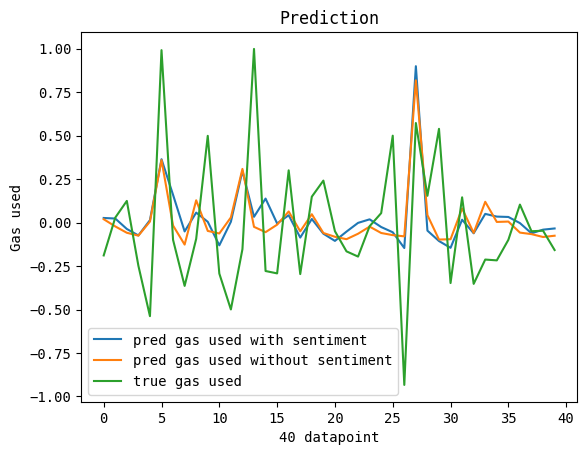

In [ ]:
plt.plot(pred[60:100], label='pred gas used with sentiment')
plt.plot(pred1[60:100], label='pred gas used without sentiment')
plt.plot(y_test[60:100], label='true gas used')
plt.title('Prediction')
plt.xlabel('40 datapoint')
plt.ylabel('Gas used')
plt.legend()
plt.savefig('Combined prediction 40 data.pdf')
plt.show()